### For Time Series(Long Short-Term Memory)

In [1]:
import pandas as pd
file_path = '/Users/wangchengrui11/Desktop/MCM_Prep/2023C/Problem_C_Data_Wordle.xlsx'

# load Excel file to examine sheets and data structure
try:
    data = pd.read_excel(file_path, sheet_name=None)  # Load all sheets
    sheet_info = {sheet: df.head() for sheet, df in data.items()}
except Exception as e:
    sheet_info = str(e)

sheet_info

{'Sheet1':    Unnamed: 0           Unnamed: 1      Unnamed: 2 Unnamed: 3  \
 0         NaN                 Date  Contest number       Word   
 1         NaN  2022-12-31 00:00:00             560      manly   
 2         NaN  2022-12-30 00:00:00             559      molar   
 3         NaN  2022-12-29 00:00:00             558      havoc   
 4         NaN  2022-12-28 00:00:00             557      impel   
 
                     Unnamed: 4           Unnamed: 5 Percent in  Unnamed: 7  \
 0  Number of  reported results  Number in hard mode       1 try    2 tries   
 1                        20380                 1899           0          2   
 2                        21204                 1973           0          4   
 3                        20001                 1919           0          2   
 4                        20160                 1937           0          3   
 
   Unnamed: 8 Unnamed: 9 Unnamed: 10 Unnamed: 11          Unnamed: 12  
 0    3 tries    4 tries     5 tries     6 t

In [2]:
import numpy as np

# Extract relevant data from Sheet1
sheet1 = data['Sheet1']
sheet1.columns = sheet1.iloc[0]  # Set the first row as header
sheet1 = sheet1[1:]  # Drop the first row

# Keep only Date and Number of reported results, and clean the data
time_series_data = sheet1[['Date', 'Number of  reported results']]
time_series_data = time_series_data.rename(columns={'Date': 'date', 'Number of  reported results': 'value'})
time_series_data['date'] = pd.to_datetime(time_series_data['date'])
time_series_data['value'] = pd.to_numeric(time_series_data['value'], errors='coerce')

# Drop rows with missing values and sort by date
time_series_data = time_series_data.dropna().sort_values('date').reset_index(drop=True)

# Display cleaned time series data
time_series_data.head()


,date,value
0,2022-01-07,80630
1,2022-01-08,101503
2,2022-01-09,91477
3,2022-01-10,107134
4,2022-01-11,153880


Epoch 1/20, Loss: 0.5842
Epoch 2/20, Loss: 0.1750
Epoch 3/20, Loss: 0.0353
Epoch 4/20, Loss: 0.0238
Epoch 5/20, Loss: 0.0185
Epoch 6/20, Loss: 0.0181
Epoch 7/20, Loss: 0.0172
Epoch 8/20, Loss: 0.0165
Epoch 9/20, Loss: 0.0168
Epoch 10/20, Loss: 0.0175
Epoch 11/20, Loss: 0.0137
Epoch 12/20, Loss: 0.0156
Epoch 13/20, Loss: 0.0141
Epoch 14/20, Loss: 0.0146
Epoch 15/20, Loss: 0.0127
Epoch 16/20, Loss: 0.0132
Epoch 17/20, Loss: 0.0147
Epoch 18/20, Loss: 0.0124
Epoch 19/20, Loss: 0.0121
Epoch 20/20, Loss: 0.0131


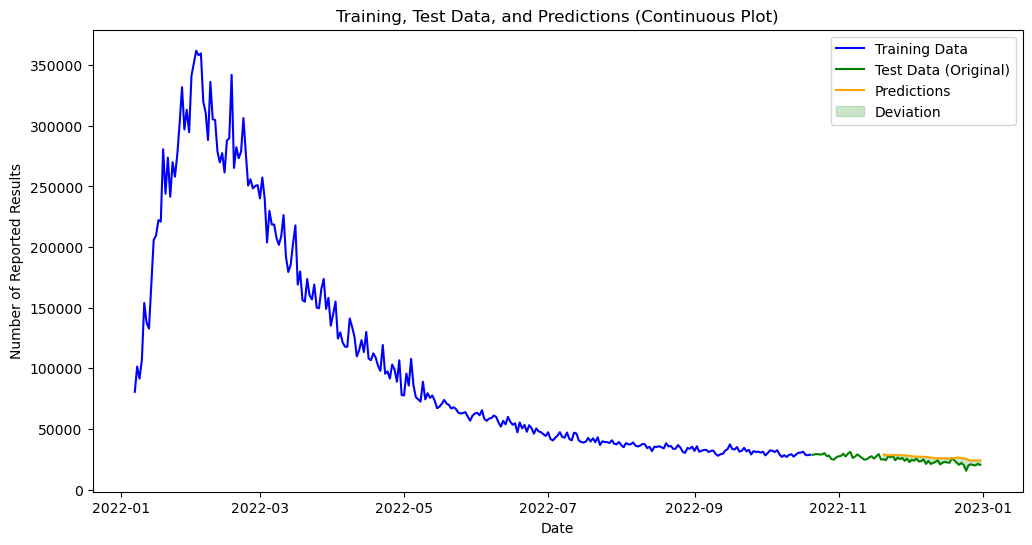

In [17]:
# Pytoch Implementation
# pip install torch

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ==========================
# Data Preprocessing
# ==========================
data = time_series_data[['date', 'value']].dropna().sort_values('date')

# Normalize the data
split = 0.8
values = data['value'].values
mean, std = np.mean(values), np.std(values)
values = (values - mean) / std
train_size = int(len(values) * split)
train_values = values[:train_size]
test_values = values[train_size:]

# ==========================
# Dataset Class
# ==========================
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ==========================
# GRU Model
# ==========================
class GRUNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h = self.gru(x)  # h has shape (num_layers, batch_size, hidden_size)
        out = self.fc(h[-1])  # Use the last layer's hidden state
        return out.squeeze(-1)  # Ensure output is (batch_size,)

# ==========================
# Model Training
# ==========================
seq_length = 30
# Training Dataset
train_dataset = TimeSeriesDataset(train_values, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Test Dataset
test_dataset = TimeSeriesDataset(test_values, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, optimizer, and loss
model = GRUNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 20
model.train()
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.unsqueeze(-1)
        y_batch = y_batch.unsqueeze(-1)  # Add feature dimension
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch.squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}")

# ==========================
# Prediction
# ==========================
model.eval()
test_predictions = []
test_targets = []
input_seq = torch.tensor(values[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.unsqueeze(-1)
        y_pred = model(x_batch).squeeze()
        test_predictions.extend(y_pred.tolist())
        test_targets.extend(y_batch.tolist())


# Denormalize predictions and targets
test_predictions = np.array(test_predictions) * std + mean
test_targets = np.array(test_targets) * std + mean

# ==========================
# Visualization
# ==========================
plt.figure(figsize=(12, 6))

# Full dates for the entire dataset
all_dates = data['date']
full_targets = values * std + mean  # Denormalize full data

# Training Data
plt.plot(all_dates[:train_size], full_targets[:train_size], label="Training Data", color="blue")

# Test Data
plt.plot(all_dates[train_size:], full_targets[train_size:], label="Test Data (Original)", color="green")

# Predictions on Test Data
plt.plot(all_dates[train_size + seq_length:], test_predictions, label="Predictions", color="orange")

# Highlight Deviation
deviation = abs(full_targets[train_size + seq_length:] - test_predictions)
plt.fill_between(all_dates[train_size + seq_length:], 
                 full_targets[train_size + seq_length:], 
                 test_predictions, color="green", alpha=0.2, label="Deviation")

# Labels and Legends
plt.title("Training, Test Data, and Predictions (Continuous Plot)")
plt.xlabel("Date")
plt.ylabel("Number of Reported Results")
plt.legend()
plt.show()



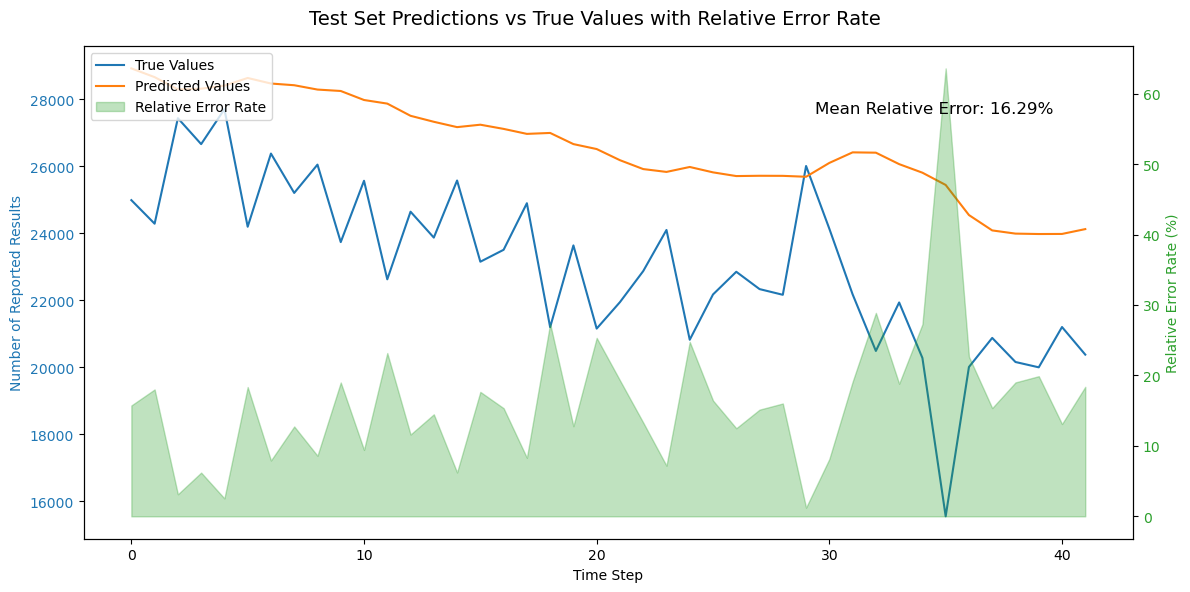

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# Calculate Relative Error Rate
# ==========================
relative_error_rate = (abs(test_targets - test_predictions) / test_targets) * 100
mean_relative_error = np.mean(relative_error_rate)

# ==========================
# Plot Test Results with Dual Axes
# ==========================
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-Axis: Plot True and Predicted Values
color_true = 'tab:blue'
color_pred = 'tab:orange'

ax1.set_xlabel("Time Step")
ax1.set_ylabel("Number of Reported Results", color=color_true)
ax1.plot(test_targets, label="True Values", color=color_true)
ax1.plot(test_predictions, label="Predicted Values", color=color_pred)
ax1.tick_params(axis='y', labelcolor=color_true)

# Secondary Y-Axis: Plot Relative Error Rate
ax2 = ax1.twinx()  # Create a secondary y-axis
color_err = 'tab:green'

ax2.set_ylabel("Relative Error Rate (%)", color=color_err)
ax2.fill_between(range(len(test_targets)), 0, relative_error_rate, color=color_err, alpha=0.3, label="Relative Error Rate")
ax2.tick_params(axis='y', labelcolor=color_err)

# ==========================
# Add Titles, Legends, and Annotation for Mean Relative Error
# ==========================
fig.suptitle("Test Set Predictions vs True Values with Relative Error Rate", fontsize=14)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Display Mean Relative Error on the Plot
plt.text(len(test_targets) * 0.7, max(relative_error_rate) * 0.9, 
         f"Mean Relative Error: {mean_relative_error:.2f}%", color="black", fontsize=12)

# Show the Plot
plt.tight_layout()
plt.show()